# 11.3. Attention Scoring Functions

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 11.3.1. Dot Product Attention

见experiments/Attention-Function.ipynb

归根到底就是先计算attention scores，再利用这个值计算softmax

### 11.3.2.1. Masked Softmax Operation

In [2]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    # x: 一个三维张量，通常表示模型输出的得分或注意力权重。
    # valid_lens: 一个一维或二维张量，用于指示序列中有效部分的长度。用于对输入 X 进行掩码操作，使得无效位置不参与 softmax 计算
    
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

这段代码定义了一个带掩码的 `softmax` 函数 (`masked_softmax`)，用于在深度学习任务中处理序列数据时，对某些位置的值进行掩码处理，以避免无效的值影响计算。它特别适用于自然语言处理（NLP）中的序列模型，比如注意力机制（Attention）。以下是代码的解释：

### 核心功能解释

#### 1. **masked_softmax函数**：

该函数接收两个输入：
- **X**：一个三维张量，通常表示模型输出的得分或注意力权重。
- **valid_lens**：一个一维或二维张量，用于指示序列中有效部分的长度。用于对输入 `X` 进行掩码操作，使得无效位置不参与 `softmax` 计算。

#### 2. **_sequence_mask函数**：

这是一个内部函数，目的是根据 `valid_lens` 对输入 `X` 进行掩码：
- **X**：表示输入的序列张量。
- **valid_len**：表示有效的序列长度，对于超出长度的部分，填充为指定的 `value`（默认是0）。
- **mask**：用来创建掩码矩阵，其中 `True` 表示有效部分，`False` 表示无效部分。

#### 3. **流程**：

- **没有`valid_lens`的情况**：直接在最后一个维度上进行 `softmax`。
- **有`valid_lens`的情况**：
  - 使用 `_sequence_mask` 对 `X` 的无效位置（长度之外的位置）进行掩码，并将它们替换为非常大的负数（`-1e6`）。在进行 `softmax` 时，这些非常大的负数会被映射到接近于 0 的概率。
  - 通过 `softmax` 函数计算得到概率分布。


### 代码细节：

1. **_sequence_mask**：根据 `valid_len` 对 `X` 的无效部分掩码，并将其值替换为 `value`。
   - `mask`：创建一个布尔掩码矩阵，表示哪些元素应该保留，哪些应该被掩盖。
   - `X[~mask] = value`：对 `mask` 中为 `False` 的位置，设置为 `value`（默认是 0）。

2. **valid_lens的处理**：
   - 如果 `valid_lens` 是一维的，它会被扩展为与 `X` 的形状匹配。
   - 然后通过 `_sequence_mask` 对 `X` 进行掩码处理，将无效的部分替换为非常小的数值（`-1e6`）。

3. **softmax计算**：最后在掩码后的 `X` 上应用 `softmax`，从而得到有效部分的概率分布。

### 总结

这个 `masked_softmax` 函数特别适用于处理变长序列，在深度学习模型（例如 Transformer）中对不同长度的输入序列进行 `softmax` 操作时使用。通过 `valid_lens` 进行掩码，确保了只在有效部分上计算 `softmax`，避免了无效值的干扰。

To illustrate how this function works, consider a minibatch of two examples of size 2x4, where their valid lengths are 2 and 3, respectively. 

As a result of the masked softmax operation, values beyond the valid lengths for each pair of vectors are all masked as zero.

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4459, 0.5541, 0.0000, 0.0000],
         [0.5048, 0.4952, 0.0000, 0.0000]],

        [[0.3355, 0.3719, 0.2926, 0.0000],
         [0.3038, 0.3705, 0.3257, 0.0000]]])

In [4]:
# another example
masked_softmax(torch.rand(3, 2, 4), torch.tensor([2, 3, 2]))

tensor([[[0.5011, 0.4989, 0.0000, 0.0000],
         [0.5478, 0.4522, 0.0000, 0.0000]],

        [[0.2715, 0.2985, 0.4300, 0.0000],
         [0.2788, 0.4322, 0.2891, 0.0000]],

        [[0.3759, 0.6241, 0.0000, 0.0000],
         [0.4576, 0.5424, 0.0000, 0.0000]]])

In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2787, 0.3838, 0.3375, 0.0000]],

        [[0.4754, 0.5246, 0.0000, 0.0000],
         [0.1718, 0.1838, 0.3247, 0.3197]]])

### 11.3.2.2. Batch Matrix Multiplication

在深度学习中，**Batch Matrix Multiplication** 是指对一批（batch）矩阵执行矩阵乘法操作，通常用于处理多个样本（批量输入）时的并行计算。它可以帮助加速在深度学习模型中计算注意力权重或神经网络的前向传播。

PyTorch 和 NumPy 都支持批量矩阵乘法操作。以下是关于如何使用这两个库执行 **Batch Matrix Multiplication** 的介绍。

### PyTorch 中的 Batch Matrix Multiplication

在 PyTorch 中，`torch.bmm()` 用于执行批量矩阵乘法。`torch.matmul()` 也支持高维张量的批量矩阵乘法。

- `torch.bmm(A, B)` 要求 `A` 和 `B` 的形状为 `(batch_size, m, n)` 和 `(batch_size, n, p)`，即每个批次都是一个 `(m, n)` 和 `(n, p)` 形状的矩阵。最终的输出形状是 `(batch_size, m, p)`。

#### 示例

```python
import torch

# 创建两组批次矩阵 A 和 B
A = torch.randn(5, 3, 4)  # 5个批次，每个矩阵是3x4
B = torch.randn(5, 4, 2)  # 5个批次，每个矩阵是4x2

# 使用 torch.bmm() 进行批量矩阵乘法
result = torch.bmm(A, B)
print(result.shape)  # 输出形状为 (5, 3, 2)
```

### NumPy 中的 Batch Matrix Multiplication

在 NumPy 中，`numpy.matmul()` 可以用于批量矩阵乘法。它支持高维数组，具体行为取决于输入的形状：

- 如果 `A` 和 `B` 都是 3D 数组（例如 `(batch_size, m, n)` 和 `(batch_size, n, p)`），则 `numpy.matmul()` 会沿着第一个维度批量执行矩阵乘法。

#### 示例

```python
import numpy as np

# 创建两组批次矩阵 A 和 B
A = np.random.randn(5, 3, 4)  # 5个批次，每个矩阵是3x4
B = np.random.randn(5, 4, 2)  # 5个批次，每个矩阵是4x2

# 使用 numpy.matmul() 进行批量矩阵乘法
result = np.matmul(A, B)
print(result.shape)  # 输出形状为 (5, 3, 2)
```

### 多维张量支持

`torch.matmul()` 和 `np.matmul()` 都支持多维张量。当输入为 3D 张量（或更高维度的张量）时，都会执行批量矩阵乘法。

- **PyTorch**: `torch.matmul(A, B)` 会自动处理多维张量。对于高于 2D 的张量，它会沿着批次维度应用矩阵乘法。
- **NumPy**: 同样，`np.matmul(A, B)` 也会自动沿着批次维度执行矩阵乘法。

#### 高维张量示例（4D 张量）

```python
# PyTorch
A = torch.randn(2, 5, 3, 4)  # 2x5批次，每个矩阵是3x4
B = torch.randn(2, 5, 4, 2)  # 2x5批次，每个矩阵是4x2
result = torch.matmul(A, B)
print(result.shape)  # 输出形状为 (2, 5, 3, 2)

# NumPy
A = np.random.randn(2, 5, 3, 4)
B = np.random.randn(2, 5, 4, 2)
result = np.matmul(A, B)
print(result.shape)  # 输出形状为 (2, 5, 3, 2)
```


$$ Q = [Q_1, Q_2,...,Q_n] $$
$$ K = [K_1, K_2,...,K_n] $$
$$ BMM(Q, k) = [Q_1K_1, Q_2K_2,...,Q_nK_n] $$

In [8]:
Q = torch.ones((2, 3, 4))
print("Q:", Q)
K = torch.ones((2, 4, 6))
print("K:", K)
print("BMM: ", torch.bmm(Q, K))

d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

Q: tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
K: tensor([[[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1.]]])
BMM:  tensor([[[4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.]],

        [[4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.],
         [4., 4., 4., 4., 4., 4.]]])


In [10]:
a = torch.ones(3, 4)
b = torch.ones(4, 6)
# [1, 1, 1, 1
#  1, 1, 1, 1
#  1, 1, 1, 1]

# [1, 1, 1, 1, 1, 1
#  1, 1, 1, 1, 1, 1
#  1, 1, 1, 1, 1, 1
#  1, 1, 1, 1, 1, 1]

# [1*1+1*1+1*1+1*1+1*1, 1*1+1*1+1*1+1*1+1*1, 1*1+1*1+1*1+1*1+1*1, 1*1+1*1+1*1+1*1+1*1, 1*1+1*1+1*1+1*1+1*1, 1*1+1*1+1*1+1*1+1*1, 1*1+1*1+1*1+1*1+1*1
#  ...
#  ...
#  ...]
print(torch.matmul(a, b))

tensor([[4., 4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4., 4.],
        [4., 4., 4., 4., 4., 4.]])


## 11.3.3. Scaled Dot Product Attention

In [11]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

`keys.transpose(1, 2)` 的作用是将 `keys` 张量的**第二维度**（`no. of key-value pairs`）和**第三维度**（`d`，特征维度）交换，以便与 `queries` 进行矩阵乘法。

在 `DotProductAttention` 中：

- `queries` 的形状是 `(batch_size, no. of queries, d)`。
- `keys` 的形状是 `(batch_size, no. of key-value pairs, d)`。

为了进行**点积注意力**计算，需要将 `queries` 和 `keys` 的最后一维（`d`）对齐进行点积。因此，需要将 `keys` 的形状从 `(batch_size, no. of key-value pairs, d)` 转换为 `(batch_size, d, no. of key-value pairs)`，即通过 `keys.transpose(1, 2)` 交换第二维和第三维。

### 点积计算：

- `queries` 的形状是 `(batch_size, no. of queries, d)`。
- `keys.transpose(1, 2)` 变成 `(batch_size, d, no. of key-value pairs)`。

这样就可以使用 **批量矩阵乘法** `torch.bmm(queries, keys.transpose(1, 2))`，计算出 `queries` 和 `keys` 之间的点积，其结果是一个形状为 `(batch_size, no. of queries, no. of key-value pairs)` 的张量。

这个输出就是**每个 query 和每个 key 之间的相似度分数**，用于后续的 softmax 和加权求和。

In [14]:
queries = torch.normal(0, 1, (2, 1, 2))
print("queries: ", queries)
keys = torch.normal(0, 1, (2, 10, 2))
print("keys: ", keys)
values = torch.normal(0, 1, (2, 10, 4))
print("values: ", values)

valid_lens = torch.tensor([2, 6])


queries:  tensor([[[-0.1933, -0.6525]],

        [[-1.2667,  0.0445]]])
keys:  tensor([[[-1.4692,  0.0432],
         [ 0.2185,  0.4542],
         [ 1.7789, -1.6600],
         [-0.4463, -0.0735],
         [-0.6156, -0.9115],
         [ 0.6116,  1.0802],
         [-0.3488,  0.4225],
         [ 2.1640,  0.2601],
         [-3.2539,  0.3244],
         [-1.9488, -2.7373]],

        [[-0.0564,  0.0604],
         [-0.3512,  1.4117],
         [ 0.3267, -1.4301],
         [-0.0409, -1.7266],
         [-0.1149,  0.4027],
         [ 0.6222, -0.8383],
         [ 1.1585, -0.2635],
         [ 2.7509, -1.3584],
         [ 1.3409,  1.4852],
         [ 1.0172, -0.3419]]])
values:  tensor([[[ 0.4734,  0.0464,  1.0230,  0.3980],
         [ 1.2151, -0.1061,  0.2331,  1.1884],
         [-0.7626, -0.1376, -0.3411, -1.8837],
         [ 0.2046,  1.0314, -0.9120,  1.2394],
         [-1.0771,  1.0042,  0.7402, -0.3134],
         [-0.1184, -0.2537,  0.9078,  0.4044],
         [-1.1080, -0.8064,  0.4437,  0.0530],

In [16]:
attention = DotProductAttention(dropout=0.5)

In [18]:
print(attention.eval())

DotProductAttention(
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
attention(queries, keys, values, valid_lens)

tensor([[[ 0.7674, -0.0141,  0.7098,  0.7113]],

        [[-0.4790, -0.8039, -0.6142, -0.2447]]])

In [ ]:
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

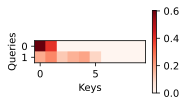

In [20]:
d2l.show_heatmaps(attention.attention_weights.reshapee((1, 1, 2, 10)), xlabel='Keys', ylabel='Queris')

## 11.3.4. Additive Attention

似乎d2l中的attention相加更加复杂一些，普通的相加就是score*weight相加

In [21]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)